# Top overlapping shell genes by weighted sum for saur cohort

In [1]:
import pandas as pd


pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
pd.set_option("display.expand_frame_repr", False)

## Read token information from bed files

In [2]:
import os
import pandas as pd
from pathlib import Path


bedDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'bed_files', 'SAUR')

bedDfList = []
for bedFile in os.listdir(bedDir):
    tubeid = bedFile.split('.')[0].split('_')[0]
    tokensDf = pd.read_csv(Path(bedDir, bedFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score'])
    tokensDf['tube_id'] = tubeid
    bedDfList.append(tokensDf)

bedDf = pd.concat(bedDfList, ignore_index=True)
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id
0,1,0,6,TTTTCTT,0.000064,ALF22G140
1,1,7,9,ACC,-0.000395,ALF22G140
2,1,10,13,GACA,0.001573,ALF22G140
3,1,14,18,AGAAT,-0.000986,ALF22G140
4,1,19,25,TAATTAT,0.000795,ALF22G140
...,...,...,...,...,...,...
176721937,5,181665,181667,CGG,-0.002273,AH21C044
176721938,5,181668,181673,CTCATC,-0.001735,AH21C044
176721939,5,181674,181676,GCA,-0.003468,AH21C044
176721940,5,181677,181680,TCCA,-0.000228,AH21C044


<Axes: >

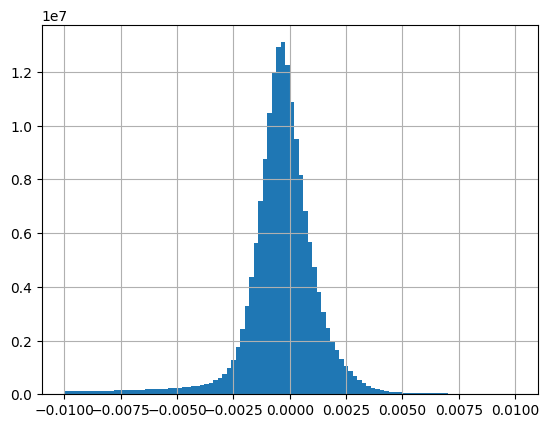

In [3]:
bedDf[(bedDf.score > -0.01) & (bedDf.score < 0.01)].score.hist(bins=100)

In [4]:
bedDf['token_length'] = bedDf.tokens.apply(lambda x: len(x))
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
0,1,0,6,TTTTCTT,0.000064,ALF22G140,7
1,1,7,9,ACC,-0.000395,ALF22G140,3
2,1,10,13,GACA,0.001573,ALF22G140,4
3,1,14,18,AGAAT,-0.000986,ALF22G140,5
4,1,19,25,TAATTAT,0.000795,ALF22G140,7
...,...,...,...,...,...,...,...
176721937,5,181665,181667,CGG,-0.002273,AH21C044,3
176721938,5,181668,181673,CTCATC,-0.001735,AH21C044,6
176721939,5,181674,181676,GCA,-0.003468,AH21C044,3
176721940,5,181677,181680,TCCA,-0.000228,AH21C044,4


In [5]:
len(bedDf.tokens.unique())

3894

In [6]:
highscoreCutoff = bedDf.score.mean() + 3 * bedDf.score.std()
highscoreCutoff

np.float64(0.012133979502852287)

In [7]:
highscoreDf = bedDf[bedDf.score > highscoreCutoff]
highscoreDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
13703,1,75447,75454,TATACTTT,0.013623,ALF22G140,8
13723,1,75557,75561,AATGA,0.014487,ALF22G140,5
13725,1,75567,75572,CCTGAG,0.015546,ALF22G140,6
13753,1,75724,75731,CTGCACCC,0.018303,ALF22G140,8
13785,1,75898,75902,GAGCA,0.018827,ALF22G140,5
...,...,...,...,...,...,...,...
176698433,5,50635,50641,AATGTTT,0.016897,AH21C044,7
176698449,5,50725,50728,ACTG,0.020198,AH21C044,4
176698513,5,51074,51079,GGCGCG,0.015019,AH21C044,6
176698639,5,51802,51807,AAATAT,0.013009,AH21C044,6


In [8]:
len(highscoreDf.tokens.unique())

1991

In [9]:
highscoreDf.shape

(286987, 7)

<Axes: >

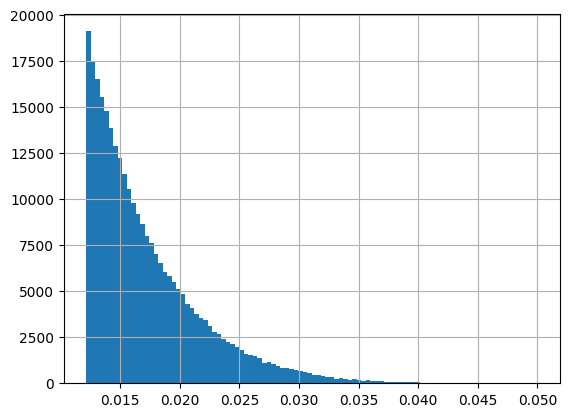

In [10]:
highscoreDf[(highscoreDf.score < 0.05)].score.hist(bins=100)

In [11]:
highscoreDf.token_length.value_counts()

token_length
6     104579
5      75597
7      51246
4      33151
8      16706
3       2680
9       1348
10       798
2        738
13        73
1         68
11         3
Name: count, dtype: int64

<Axes: xlabel='token_length', ylabel='Count'>

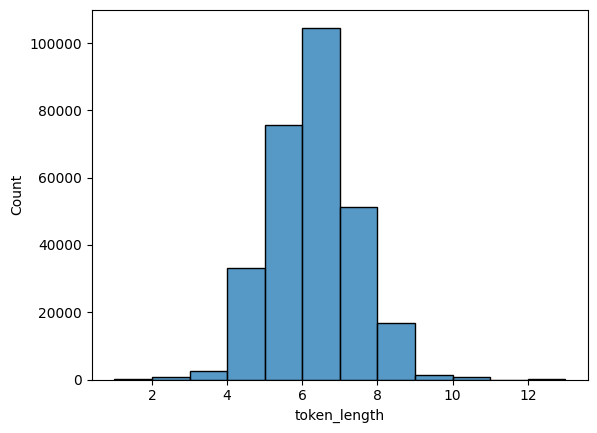

In [12]:
import seaborn as sns

sns.histplot(highscoreDf.token_length, binwidth=1)

## Read shell genes

In [13]:
import os
from pathlib import Path

import pandas as pd


coreGenesPath = Path(os.environ['GENOMICS_DATA_BASE'], 'annotations', 's_aureus', 'panaroo_strict', 'shell_genes.csv')
coreGenesDf = pd.read_csv(coreGenesPath)
coreGenesDf['Gene'] = coreGenesDf.Gene.str.lower()
coreGenesDf

,Gene,Occurrences
0,sdrg~~~clfb,529
1,set19~~~ssl4~~~ssl3~~~set18,528
2,acrr~~~tetr,526
3,sigs,523
4,group_1045,523
...,...,...
729,group_1777,84
730,group_1666,84
731,group_1590,84
732,group_857,84


## Read bed files containing overlapping tokens and attribution scores

In [14]:
from tqdm import tqdm

import os
import pandas as pd
from pathlib import Path


annotationOverlappingFilesDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'overlapping_with_annotations', 'SAUR')

annotationOverlappingDfList = []
for annotationOverlappingFile in tqdm(os.listdir(annotationOverlappingFilesDir)):
    df = pd.read_csv(Path(annotationOverlappingFilesDir, annotationOverlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
    df = df[df.feature_type.isin(['CDS', 'ncRNA', 'oriC', 'regulatory_region', 'oriT'])]
    df['tube_code'] = [annotationOverlappingFile.split('_')[0]]*df.shape[0]
    df = df[df.tokens.apply(lambda x: (len(x) >= 5))].reset_index()
    df['gene'] = df.gene.str.lower()
    coreDf = df[df.gene.isin(coreGenesDf.Gene)]
    annotationOverlappingDfList.append(coreDf)
annotationOverlappingDf = pd.concat(annotationOverlappingDfList, ignore_index=True)
annotationOverlappingDf = annotationOverlappingDf.drop_duplicates()
annotationOverlappingDf


 10%|▉         | 50/515 [00:36<06:13,  1.24it/s]

 13%|█▎        | 66/515 [00:46<05:07,  1.46it/s]/tmp/ipykernel_25144/1185420913.py:12: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Path(annotationOverlappingFilesDir, annotationOverlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
 24%|██▎       | 122/515 [01:27<03:53,  1.68it/s]/tmp/ipykernel_25144/1185420913.py:12: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Path(annotationOverlappingFilesDir, annotationOverlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
 33%|███▎      | 172/515 [02:04<04:02,  1.41it/s]/tmp/ipykernel_25144/1185420913.py:12: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
 

,index,contig_id,start_position,end_position,tokens,score,feature_type,id,name,gene,atributes,tube_code
0,16105,1,104892,104896,ACTAA,-0.002066,CDS,OILJNO_00485,ABC-type multidrug transport system%2C permease component,yadh,"ID=OILJNO_00485;Name=ABC-type multidrug transport system%2C permease component;locus_tag=OILJNO_00485;product=ABC-type multidrug transport system%2C permease component;Dbxref=COG:COG0842,COG:V,RefSeq:WP_000603971.1,SO:0001217,UniParc:UPI0002BAEE00,UniRef:UniRef100_UPI0002BAEE00,UniRef:UniRef50_T1Y929,UniRef:UniRef90_T1Y929;gene=yadH",AH20I016
1,16107,1,104897,104901,GTTAC,0.001371,CDS,OILJNO_00485,ABC-type multidrug transport system%2C permease component,yadh,"ID=OILJNO_00485;Name=ABC-type multidrug transport system%2C permease component;locus_tag=OILJNO_00485;product=ABC-type multidrug transport system%2C permease component;Dbxref=COG:COG0842,COG:V,RefSeq:WP_000603971.1,SO:0001217,UniParc:UPI0002BAEE00,UniRef:UniRef100_UPI0002BAEE00,UniRef:UniRef50_T1Y929,UniRef:UniRef90_T1Y929;gene=yadH",AH20I016
2,16109,1,104902,104907,TTGAAA,-0.014027,CDS,OILJNO_00485,ABC-type multidrug transport system%2C permease component,yadh,"ID=OILJNO_00485;Name=ABC-type multidrug transport system%2C permease component;locus_tag=OILJNO_00485;product=ABC-type multidrug transport system%2C permease component;Dbxref=COG:COG0842,COG:V,RefSeq:WP_000603971.1,SO:0001217,UniParc:UPI0002BAEE00,UniRef:UniRef100_UPI0002BAEE00,UniRef:UniRef50_T1Y929,UniRef:UniRef90_T1Y929;gene=yadH",AH20I016
3,16111,1,104908,104912,ATCGA,-0.010983,CDS,OILJNO_00485,ABC-type multidrug transport system%2C permease component,yadh,"ID=OILJNO_00485;Name=ABC-type multidrug transport system%2C permease component;locus_tag=OILJNO_00485;product=ABC-type multidrug transport system%2C permease component;Dbxref=COG:COG0842,COG:V,RefSeq:WP_000603971.1,SO:0001217,UniParc:UPI0002BAEE00,UniRef:UniRef100_UPI0002BAEE00,UniRef:UniRef50_T1Y929,UniRef:UniRef90_T1Y929;gene=yadH",AH20I016
4,16113,1,104913,104917,ATTTA,-0.006856,CDS,OILJNO_00485,ABC-type multidrug transport system%2C permease component,yadh,"ID=OILJNO_00485;Name=ABC-type multidrug transport system%2C permease component;locus_tag=OILJNO_00485;product=ABC-type multidrug transport system%2C permease component;Dbxref=COG:COG0842,COG:V,RefSeq:WP_000603971.1,SO:0001217,UniParc:UPI0002BAEE00,UniRef:UniRef100_UPI0002BAEE00,UniRef:UniRef50_T1Y929,UniRef:UniRef90_T1Y929;gene=yadH",AH20I016
...,...,...,...,...,...,...,...,...,...,...,...,...
3577973,333317,5,181083,181089,TTTTTAT,-0.000664,CDS,KKIOAG_10420,primosomal protein DnaI,dnai,"ID=KKIOAG_10420;Name=primosomal protein DnaI;locus_tag=KKIOAG_10420;product=primosomal protein DnaI;Dbxref=COG:COG1484,COG:L,RefSeq:WP_000808621.1,SO:0001217,UniParc:UPI00000CABBE,UniRef:UniRef100_A0A0U1MMS5,UniRef:UniRef50_B9DNB8,UniRef:UniRef90_A0A0U1MMS5;gene=dnaI",AH21K020
3577974,333318,5,181090,181095,CAGGAG,-0.000078,CDS,KKIOAG_10420,primosomal protein DnaI,dnai,"ID=KKIOAG_10420;Name=primosomal protein DnaI;locus_tag=KKIOAG_10420;product=primosomal protein DnaI;Dbxref=COG:COG1484,COG:L,RefSeq:WP_000808621.1,SO:0001217,UniParc:UPI00000CABBE,UniRef:UniRef100_A0A0U1MMS5,UniRef:UniRef50_B9DNB8,UniRef:UniRef90_A0A0U1MMS5;gene=dnaI",AH21K020
3577975,333319,5,181096,181102,AAAATTT,-0.000623,CDS,KKIOAG_10420,primosomal protein DnaI,dnai,"ID=KKIOAG_10420;Name=primosomal protein DnaI;locus_tag=KKIOAG_10420;product=primosomal protein DnaI;Dbxref=COG:COG1484,COG:L,RefSeq:WP_000808621.1,SO:0001217,UniParc:UPI00000CABBE,UniRef:UniRef100_A0A0U1MMS5,UniRef:UniRef50_B9DNB8,UniRef:UniRef90_A0A0U1MMS5;gene=dnaI",AH21K020
3577976,333320,5,181103,181107,CAGAA,-0.000803,CDS,KKIOAG_10420,primosomal protein DnaI,dnai,"ID=KKIOAG_10420;Name=primosomal protein DnaI;locus_tag=KKIOAG_10420;product=primosomal protein DnaI;Dbxref=COG:COG1484,COG:L,RefSeq:WP_000808621.1,SO:0001217,UniParc:UPI00000CABBE,UniRef:UniRef100_A0A0U1MMS5,UniRef:UniRef50_B9DNB8,UniRef:UniRef90_A0A0U1MMS5;gene=dnaI",AH21K020


In [15]:
from tqdm import tqdm


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

amrOverlappingDfList = []
for tubeId in tqdm(bedDf.tube_id.unique()):
    tubeidHighscoreDf = highscoreDf[highscoreDf.tube_id == tubeId]
    amrfinderFile = Path(amrfinderDir, tubeId + '_amr_results.txt')
    if(amrfinderFile.exists()):
        amrfinderDf = pd.read_csv(amrfinderFile, sep='\t')
        mergedDf = tubeidHighscoreDf.merge(
            amrfinderDf,
            how='inner',
            left_on = ['contig_id'],
            right_on = ['Contig id'],
        )
        mergedDf['tube_code'] = tubeId
        tubeidOverlappingDf = mergedDf[(mergedDf.start_position >= mergedDf.Start) & (mergedDf.end_position <= mergedDf.Stop)]
        amrOverlappingDfList.append(tubeidOverlappingDf)

amrOverlappingDf = pd.concat(amrOverlappingDfList, ignore_index=True)
amrOverlappingDf['Gene symbol'] = amrOverlappingDf['Gene symbol'].str.lower()
amrOverlappingDf

100%|██████████| 557/557 [00:09<00:00, 59.67it/s]


,contig_id,start_position,end_position,tokens,score,tube_id,token_length,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description,tube_code
0,3,92632,92637,TGAAGT,0.016457,ALF22G140,6,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
1,3,92734,92739,TAAACT,0.012154,ALF22G140,6,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
2,3,93110,93114,AAAAC,0.013360,ALF22G140,5,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
3,3,93281,93285,GAGTA,0.012412,ALF22G140,5,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
4,5,115189,115193,CCAAT,0.013918,AH20K063,5,NaN,5,113439,115193,+,blar1,beta-lactam sensor/signal transducer BlaR1,core,AMR,AMR,BETA-LACTAM,BETA-LACTAM,BLASTX,585,585,100.0,91.45,585,WP_001096386.1,beta-lactam sensor/signal transducer BlaR1,NaN,NaN,AH20K063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606,3,313940,313945,CAGGTG,0.012849,AH20L076,6,NaN,3,312704,314056,+,mepa,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
1607,3,313975,313979,CTTTG,0.014194,AH20L076,5,NaN,3,312704,314056,+,mepa,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
1608,3,314026,314030,ACAGT,0.012561,AH20L076,5,NaN,3,312704,314056,+,mepa,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
1609,1,464540,464543,TTGA,0.013898,AH21C044,4,NaN,1,464367,465893,-,aur,zinc metalloproteinase aureolysin,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,509,509,100.0,99.21,509,EHO93748.1,zinc metalloproteinase aureolysin,NaN,NaN,AH21C044


In [16]:
overlappingDf = pd.concat(
    [
        annotationOverlappingDf[['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'gene', 'name', 'tube_code']],
        amrOverlappingDf[['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'Gene symbol', 'Sequence name', 'tube_code']].rename(columns={'Gene symbol': 'gene', 'Sequence name': 'name'})
    ],
    names=['contig_id', 'start_position', 'end_position', 'tokens', 'gene'],
    ignore_index=False
)
overlappingDf

,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
0,1,104892,104896,ACTAA,-0.002066,yadh,ABC-type multidrug transport system%2C permease component,AH20I016
1,1,104897,104901,GTTAC,0.001371,yadh,ABC-type multidrug transport system%2C permease component,AH20I016
2,1,104902,104907,TTGAAA,-0.014027,yadh,ABC-type multidrug transport system%2C permease component,AH20I016
3,1,104908,104912,ATCGA,-0.010983,yadh,ABC-type multidrug transport system%2C permease component,AH20I016
4,1,104913,104917,ATTTA,-0.006856,yadh,ABC-type multidrug transport system%2C permease component,AH20I016
...,...,...,...,...,...,...,...,...
1606,3,313940,313945,CAGGTG,0.012849,mepa,multidrug efflux MATE transporter MepA,AH20L076
1607,3,313975,313979,CTTTG,0.014194,mepa,multidrug efflux MATE transporter MepA,AH20L076
1608,3,314026,314030,ACAGT,0.012561,mepa,multidrug efflux MATE transporter MepA,AH20L076
1609,1,464540,464543,TTGA,0.013898,aur,zinc metalloproteinase aureolysin,AH21C044


## Get overlapping genes for high-score tokens

In [17]:
highscoreTokenOverlapsDf = overlappingDf.merge(
    highscoreDf[['contig_id', 'start_position', 'end_position', 'tokens']],
    on=['contig_id', 'start_position', 'end_position', 'tokens'],
    how='inner',
)
highscoreTokenOverlapsDf

,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
0,5,277628,277633,AATAGA,0.013860,araj,putative arabinose efflux permease AraJ%2C MFS family,AH20I016
1,5,278493,278497,TACTT,0.014485,araj,putative arabinose efflux permease AraJ%2C MFS family,AH20I016
2,1,40263,40270,AGATATTT,0.024095,tarm,Poly(ribitol-phosphate) alpha-N-acetylglucosaminyltransferase,AH19C024
3,1,40263,40270,AGATATTT,0.024095,tarm,Poly(ribitol-phosphate) alpha-N-acetylglucosaminyltransferase,AH19C024
4,1,40263,40270,AGATATTT,0.024095,tarm,Poly(ribitol-phosphate) alpha-N-acetylglucosaminyltransferase,AH19C024
...,...,...,...,...,...,...,...,...
11215,3,313975,313979,CTTTG,0.014194,mepa,multidrug efflux MATE transporter MepA,AH20L076
11216,3,314026,314030,ACAGT,0.012561,mepa,multidrug efflux MATE transporter MepA,AH20L076
11217,1,464540,464543,TTGA,0.013898,aur,zinc metalloproteinase aureolysin,AH21C044
11218,5,67876,67879,TTGA,0.013503,blai,penicillinase repressor BlaI,AH21C044


## Calculate weighted sum for all the genes overlapping with high-score tokens

In [18]:
import numpy as np


geneWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['gene']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})
geneWeightedsumDf

/tmp/ipykernel_25144/2423154480.py:4: FutureWarning: The provided callable <function sum at 0x74e81c198280> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  geneWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['gene']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})


,gene,weighted_sum
0,abif,1.328051
1,acra,0.088884
2,araj,15.239124
3,arga,0.290316
4,arsb,3.210986
...,...,...
115,yadh,0.789980
116,yjaz,1.193714
117,ykfc,0.012320
118,ymfn,0.903575


## Visualise weighted sum

<Axes: xlabel='weighted_sum', ylabel='Count'>

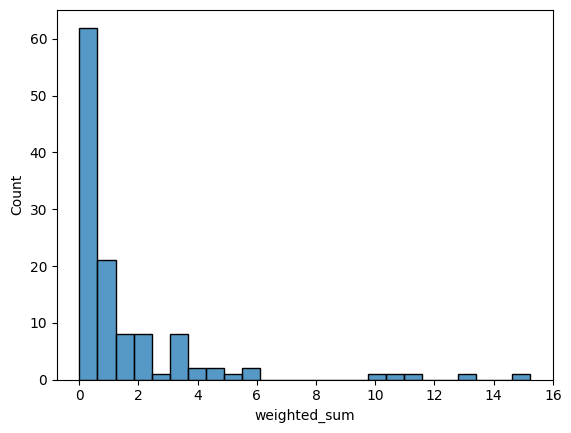

In [19]:
import seaborn as sns


sns.histplot(geneWeightedsumDf.weighted_sum)

## Top genes based on the weighted sum

In [20]:
weightedsumCutoff = geneWeightedsumDf.weighted_sum.mean() + (2 * geneWeightedsumDf.weighted_sum.std())
weightedsumCutoff

np.float64(6.71634840027345)

In [21]:
geneWeightedsumDf[geneWeightedsumDf.weighted_sum > weightedsumCutoff].sort_values(by=['weighted_sum'], ascending=False)

,gene,weighted_sum
2,araj,15.239124
71,sasc,13.237492
105,tet(38),11.012847
110,ugpq,10.708685
28,esxd,10.052441


## Create gene-type lookup table from amrfinderplus annotations

In [22]:
import os

import pandas as pd

from pathlib import Path


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

amrfinderDfList = []
for amrfinderFile in os.listdir(amrfinderDir):
    amrfinderDf = pd.read_csv(Path(amrfinderDir, amrfinderFile), sep='\t')
    amrfinderDfList.append(amrfinderDf)

allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)
allAmrfinderDf

/tmp/ipykernel_25144/536070399.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)


,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description
0,NaN,1,83926,85452,-,aur,zinc metalloproteinase aureolysin,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,509,509,100.00,99.41,509,EHO93748.1,zinc metalloproteinase aureolysin,NaN,NaN
1,NaN,1,128415,129464,+,icaC,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,plus,VIRULENCE,VIRULENCE,NaN,NaN,EXACTX,350,350,100.00,100.00,350,AUU58561.1,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,NaN,NaN
2,NaN,1,150950,154498,-,cna,collagen adhesin Cna,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1183,1183,100.00,98.31,1183,BAB96477.1,collagen adhesin Cna,NaN,NaN
3,NaN,1,277464,278813,+,tet(38),tetracycline efflux MFS transporter Tet(38),core,AMR,AMR,TETRACYCLINE,TETRACYCLINE,EXACTX,450,450,100.00,100.00,450,WP_001100300.1,tetracycline efflux MFS transporter Tet(38),NaN,NaN
4,NaN,1,505300,506652,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.00,99.33,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57610,NaN,17,83399,84580,-,emrD,multidrug efflux MFS transporter EmrD,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,394,394,100.00,99.24,394,ACN65732.1,multidrug efflux MFS transporter EmrD,NaN,NaN
57611,NaN,2,213498,214724,-,kdeA,multidrug efflux MFS transporter KdeA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,409,410,99.76,99.02,409,ABR76310.1,multidrug efflux MFS transporter KdeA,NaN,NaN
57612,NaN,3,59710,60882,+,oqxA,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,BLASTX,391,391,100.00,99.23,391,WP_002914189.1,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,NaN,NaN
57613,NaN,3,60909,64058,+,oqxB9,multidrug efflux RND transporter permease subunit OqxB9,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,ALLELEX,1050,1050,100.00,100.00,1050,WP_012967412.1,multidrug efflux RND transporter permease subunit OqxB9,NaN,NaN


In [23]:
genetypeLookupDf = allAmrfinderDf[['Gene symbol', 'Element type']].drop_duplicates()
genetypeLookupDf['Gene symbol'] = genetypeLookupDf['Gene symbol'].str.lower()
genetypeLookupDf

,Gene symbol,Element type
0,aur,VIRULENCE
1,icac,VIRULENCE
2,cna,VIRULENCE
3,tet(38),AMR
4,mepa,AMR
...,...,...
55837,blapdc-58,AMR
56358,blaact-49,AMR
56951,blandm-4,AMR
56963,aac(6')-ib-cr,AMR


## Read vfdb info

In [24]:
import os
import pandas as pd
from pathlib import Path


vfdbInfoFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'VFDB_info.csv')
vfdbInfoDf = pd.read_csv(vfdbInfoFile)
vfdbInfoDf['Label'] = vfdbInfoDf['Label'].str.lower()
vfdbInfoDf

,Column,ID,Label,Description,Source,Class
0,1,c0393,vat,hemoglobin protease,Escherichia coli O6:K2:H1 CFT073 (UPEC),Autotransporters
1,2,APECO1_O1CoBM73,tsh,Tsh,Escherichia coli O1:K1:H7 (APEC),Autotransporters
2,3,Q673F0_ECOLX,rpea,putative SPATE autotransporter; similar to the SPATE proteins,Escherichia coli plasmid pRAP strain REPEC 83/39,Autotransporters
3,4,ECSF_4010,ecsf_4010,phage protein,Escherichia coli SE15,Autotransporters
4,5,EcSMS35_3921,ecsms35_3921,outer membrane autotransporter,Escherichia coli SMS-3-5 (environmental),Autotransporters
...,...,...,...,...,...,...
249,250,c5077,yddo,ABC transporter ATP-binding protein,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
250,251,c5078,c5078,oligopeptide ABC transporter,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
251,252,c5079,yddq,ABC transporter permease,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
252,253,c5080,yddr,ABC transporter permease,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes


## Read vf collection

In [25]:
import os
import pandas as pd
from pathlib import Path


vfCollectionDescriptionFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'ecoli_VF_collection_description.tsv')
vfCollectionDescriptionDf = pd.read_csv(vfCollectionDescriptionFile, sep='\t')
vfCollectionDescriptionDf['gene'] = vfCollectionDescriptionDf['gene'].str.lower()
vfCollectionDescriptionDf

,gene,locus tag,accession number (protein_id),description,reference,source,class
0,aap,EC042_pAA055,NaN,dispersin,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
1,aata,EC042_pAA008,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
2,aatb,EC042_pAA009,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
3,aatc,EC042_pAA010,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
4,aatd,EC042_pAA011,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
...,...,...,...,...,...,...,...
1064,lngj,NaN,ABU50049,"longus pili, coli surface antigen CS20",Escherichia coli O8:H9 E9034A (ETEC),VFDB R3,Type_4_pilus
1065,lngp,NaN,ABU50050,"longus pili, coli surface antigen CS20",Escherichia coli O8:H9 E9034A (ETEC),VFDB R3,Type_4_pilus
1066,etsa,APECO1_O1CoBM197,YP_001481352,ABC transporter,Escherichia coli O1:K1:H7 APEC O1 plasmid pAPEC-O1-ColBM (APEC),manually,Other_virulence_gene
1067,etsb,APECO1_O1CoBM198,YP_001481353,ABC transporter,Escherichia coli O1:K1:H7 APEC O1 plasmid pAPEC-O1-ColBM (APEC),manually,Other_virulence_gene


## Read ABRicate

In [26]:
import os
import pandas as pd
from pathlib import Path


abricateFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'ABRicate.csv')
abricateDf = pd.read_csv(abricateFile)
abricateDf['gene'] = abricateDf['gene'].str.lower()
abricateDf

,gene,type
0,aaa23990,heat-stable enterotoxin
1,aaa24093,heat labile enterotoxin type IIa A
2,aaa24094,heat labile enterotoxin type IIa B
3,apeco1_1753,hypothetical protein
4,apeco1_1761,hypothetical protein
...,...,...
2696,ygeh,transcriptional regulator
2697,yggr,
2698,yghg,
2699,yijp,


## Add gene descriptions to the top genes

In [27]:
import pandas as pd

pd.set_option('display.max_rows', None)


geneWeightedsumDf[geneWeightedsumDf.weighted_sum > weightedsumCutoff].sort_values(by=['weighted_sum'], ascending=False).merge(
    highscoreTokenOverlapsDf[['gene', 'name']].drop_duplicates(),
    on=['gene'],
    how='inner'
).merge(
    genetypeLookupDf,
    left_on=['gene'],
    right_on=['Gene symbol'],
    how='left'
).rename(
    columns={'Element type': 'AMR Finder Type'}
).merge(
    vfdbInfoDf,
    left_on=['gene'],
    right_on=['Label'],
    how='left'
).rename(
    columns={'Class': 'VFDB Type'}
).merge(
    vfCollectionDescriptionDf,
    on=['gene'],
    how='left'
).rename(
    columns={'class': 'VF Collection Type'}
)[['gene', 'name', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type']].drop_duplicates(subset=['gene', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type'])

,gene,name,weighted_sum,AMR Finder Type,VFDB Type,VF Collection Type
0,araj,putative arabinose efflux permease AraJ%2C MFS family,15.239124,NaN,NaN,NaN
1,sasc,LPXTG-anchored repetitive surface protein SasC,13.237492,NaN,NaN,NaN
2,tet(38),tetracycline efflux MFS transporter Tet(38),11.012847,AMR,NaN,NaN
3,ugpq,Glycerophosphoryl diester phosphodiesterase,10.708685,NaN,NaN,NaN
4,esxd,type VII secretion system secreted protein EsxD,10.052441,NaN,NaN,NaN


## Save all gene hits

In [28]:
import os
import pandas as pd
from pathlib import Path


outputFile = Path(os.environ['GENOMICS_DATA_BASE'], 'temp', 'saur_top_shell_genes_all_overlaping_3sd_tokens.csv')
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False).merge(
    highscoreTokenOverlapsDf[['gene', 'name']].drop_duplicates(),
    on=['gene'],
    how='inner'
).merge(
    genetypeLookupDf,
    left_on=['gene'],
    right_on=['Gene symbol'],
    how='left'
).rename(
    columns={'Element type': 'AMR Finder Type'}
).merge(
    vfdbInfoDf,
    left_on=['gene'],
    right_on=['Label'],
    how='left'
).rename(
    columns={'Class': 'VFDB Type'}
).merge(
    vfCollectionDescriptionDf,
    on=['gene'],
    how='left'
).rename(
    columns={'class': 'VF Collection Type'}
)[['gene', 'name', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type']].drop_duplicates().to_csv(outputFile, index=False)